In [1]:
from typing import Optional, Iterable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from detector import SCVAEDetector

## Experiments with a univariate Twitter dataset

Dataset source: The NAB anomaly benchmark.

We will split it to train and test and try to see, what parts of the data are considered anomalous by the network.

The dataset contains over 90 multivariate time series. 

Let's use the last 10 series for anomaly detection and the rest for training.

In [2]:
def load_twitter_dataset():
    df = pd.read_csv("../datasets/nab/realTweets/realTweets/Twitter_volume_GOOG.csv").drop(columns=['timestamp'])  
    id_cols = []    
    return df, id_cols

data, _ = load_twitter_dataset()

In [3]:
split_point = int(0.9 * len(data))
train_data = data.iloc[:split_point,:].copy()
test_data = data.iloc[split_point:,:].copy()

## MSE anomaly score

Anomaly score calculated using average MSE of 100 reconstructed samples against the real time-window. The higher the value, the more significant anomaly detected.

In [6]:
scvae = SCVAEDetector(latent_dim=4,time_window=16,batch_size=64,id_columns=[])
scvae.fit(train_data, learning_rate = 0.001, epochs=100)
    
# might take a while :) we generate 100 samples in each shift of the rolling time window
test_res = scvae.predict_anomaly_scores(test_data)

## Test data

As we can see, anomaly score correlates nicely with higher anomalous traffic in twitter data.

Please note that anomaly score for a particular data point is influenced by all time windows containing the sample. This effectively leads to the anomaly score seeing both into the future and past by a half of the time window.

(-1.0, 15.0)

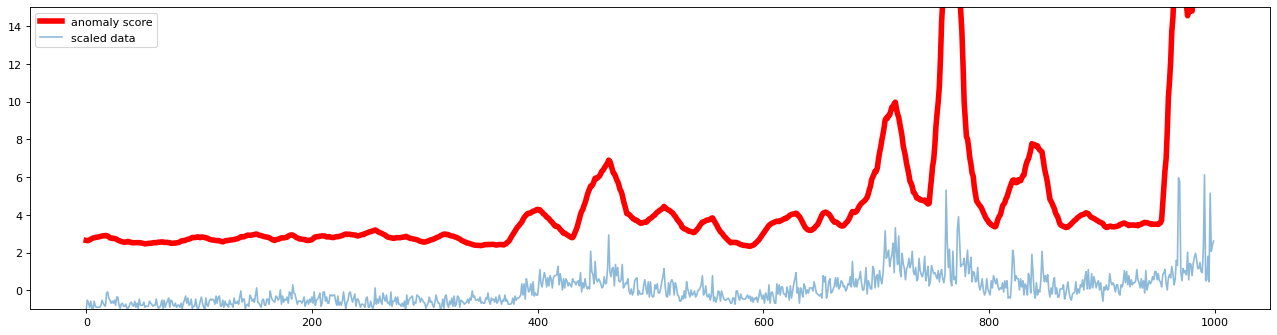

In [13]:
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(scvae._scaler.transform(test_data[500:1500]), alpha=0.5, label='scaled data')
plt.plot(np.array(test_res[500:1500]), lw=5, c='red', label='anomaly score')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels)
plt.ylim(-1,15)